In [1]:
import cfgrib
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from sklearn.preprocessing import MinMaxScaler
sys.path.append("..")

from baselines.data_processor import DataProcessor
from baselines.cnn.cnn import UNet

c:\Users\iwama\Desktop\Maciej\Eng\meteoapp-data\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022-2div.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
n_features = len(feature_list)
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# Normalize the data
scalers = []
for i in range(n_features):
    scaler = MinMaxScaler()
    og_shape = data[..., i].shape
    data[..., i] = scaler.fit_transform(data[..., i].reshape((-1, 1))).reshape(og_shape)
    scalers.append(scaler)

In [5]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [6]:
X_train.shape, y_train.shape

((1142, 32, 48, 3, 6), (1142, 32, 48, 2, 6))

In [7]:
X_train, X_test, y_train, y_test = np.float32(X_train), np.float32(X_test), np.float32(y_train), np.float32(y_test)
# X_train = X_train.reshape(X_train.shape[0], 32, 48, s*len(feature_list))
# y_train = y_train.reshape(y_train.shape[0], 32, 48, fh*len(feature_list))
# X_test = X_test.reshape(X_test.shape[0], 32, 48, s*len(feature_list))
# y_test = y_test.reshape(y_test.shape[0], 32, 48, fh*len(feature_list))

In [8]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [9]:
train = np.concatenate([X_train, y_train], axis=3)
test = np.concatenate([X_test, y_test], axis=3)

In [10]:
# X_train = X_train.transpose(0, 3, 1, 2)
# y_train = y_train.transpose(0, 3, 1, 2)
# X_test = X_test.transpose(0, 3, 1, 2)
# y_test = y_test.transpose(0, 3, 1, 2)
train = train.transpose(0, 3, 4, 1, 2)
test = test.transpose(0, 3, 4, 1, 2)
# (Samples, timestamps, features, lat, lon)

In [11]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape
train.shape, test.shape

((1142, 5, 6, 32, 48), (286, 5, 6, 32, 48))

In [12]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Device:", device)

Device: cuda


In [13]:
model = UNet(features=n_features, s=s, fh=fh).to(device)

In [17]:
training_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [18]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
num_epochs = 100
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    total_loss = 0
    for batch in training_loader:
        inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
        labels = batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / train.shape[0]
    print(f"Epoch {epoch+1}/{num_epochs}:\nTrain Loss: {avg_loss:.4f}")
    train_loss_list.append(avg_loss)

    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
            labels = batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / test.shape[0]
    print(f"Val Loss: {avg_val_loss:.4f}\n---------")
    val_loss_list.append(avg_val_loss)

Epoch 1/100:
Train Loss: 0.0209
Val Loss: 0.0197
---------
Epoch 2/100:
Train Loss: 0.0196
Val Loss: 0.0204
---------
Epoch 3/100:
Train Loss: 0.0189
Val Loss: 0.0194
---------
Epoch 4/100:
Train Loss: 0.0184
Val Loss: 0.0189
---------
Epoch 5/100:
Train Loss: 0.0182
Val Loss: 0.0186
---------
Epoch 6/100:
Train Loss: 0.0181
Val Loss: 0.0183
---------
Epoch 7/100:
Train Loss: 0.0177
Val Loss: 0.0198
---------
Epoch 8/100:
Train Loss: 0.0174
Val Loss: 0.0183
---------
Epoch 9/100:
Train Loss: 0.0174
Val Loss: 0.0204
---------
Epoch 10/100:
Train Loss: 0.0173
Val Loss: 0.0183
---------
Epoch 11/100:
Train Loss: 0.0169
Val Loss: 0.0173
---------
Epoch 12/100:
Train Loss: 0.0168
Val Loss: 0.0182
---------
Epoch 13/100:
Train Loss: 0.0169
Val Loss: 0.0171
---------
Epoch 14/100:
Train Loss: 0.0165
Val Loss: 0.0187
---------
Epoch 15/100:
Train Loss: 0.0165
Val Loss: 0.0173
---------
Epoch 16/100:
Train Loss: 0.0163
Val Loss: 0.0186
---------
Epoch 17/100:
Train Loss: 0.0163
Val Loss: 0.0169

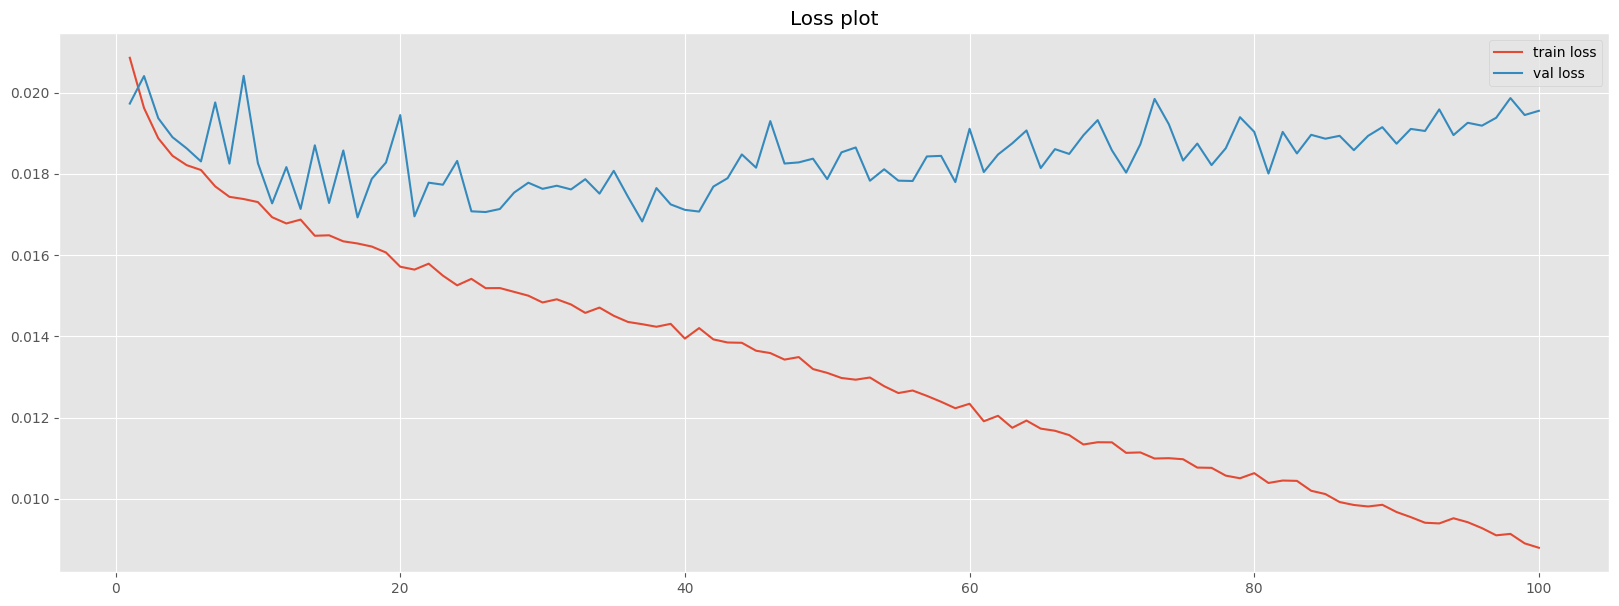

In [21]:
plt.style.use('ggplot')

x = np.arange(1, 101)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x ,val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error

def plot_predictions(y_hat, y_test, max_samples):
        features = 6
        fh = 2
        s = 3
        feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
        for i in range(max_samples):
            y_test_sample, y_hat_sample = y_test[i], y_hat[i]
            fig, ax = plt.subplots(
                features, 3 * fh, figsize=(10 * fh, 3 * features)
            )

            for j in range(features):
                cur_feature = feature_list[j]
                y_test_sample_feature_j = y_test_sample[..., j].reshape(-1, 1)
                y_hat_sample_feature_j = y_hat_sample[..., j].reshape(-1, 1)
                mse = mean_squared_error(
                    y_test_sample_feature_j, y_hat_sample_feature_j
                )
                rmse = np.sqrt(mse)
                std = np.std(y_test_sample_feature_j)
                sqrt_n = np.sqrt(y_test_sample_feature_j.shape[0])
                print(f"{cur_feature} => RMSE:  {round(rmse,5)}; SE: {std / sqrt_n}")

                for k in range(3 * fh):
                    ts = k // 3
                    if k % 3 == 0:
                        title = rf"$X_{{{cur_feature},t+{ts+1}}}$"
                        value = y_test[i, ..., ts, j]
                        cmap = plt.cm.coolwarm
                    elif k % 3 == 1:
                        title = rf"$\hat{{X}}_{{{cur_feature},t+{ts+1}}}$"
                        value = y_hat[i, ..., ts, j]
                        cmap = plt.cm.coolwarm
                    else:
                        title = rf"$|X - \hat{{X}}|_{{{cur_feature},t+{ts+1}}}$"
                        value = np.abs(y_test[i, ..., ts, j] - y_hat[i, ..., ts, j])
                        cmap = "binary"
                    pl = ax[j, k].imshow(value, cmap=cmap)
                    ax[j, k].set_title(title)
                    ax[j, k].axis("off")
                    _ = fig.colorbar(pl, ax=ax[j, k], fraction=0.15)
            plt.show()

t2m => RMSE:  2.31141996383667; SE: 0.032738486710136766
sp => RMSE:  6.169360160827637; SE: 0.3575582225505027
tcc => RMSE:  0.23128999769687653; SE: 0.0038791471946995316
u10 => RMSE:  2.017669916152954; SE: 0.037792077607971195
v10 => RMSE:  1.6336300373077393; SE: 0.026309678133272712
tp => RMSE:  0.0003699999942909926; SE: 6.163118226965375e-06


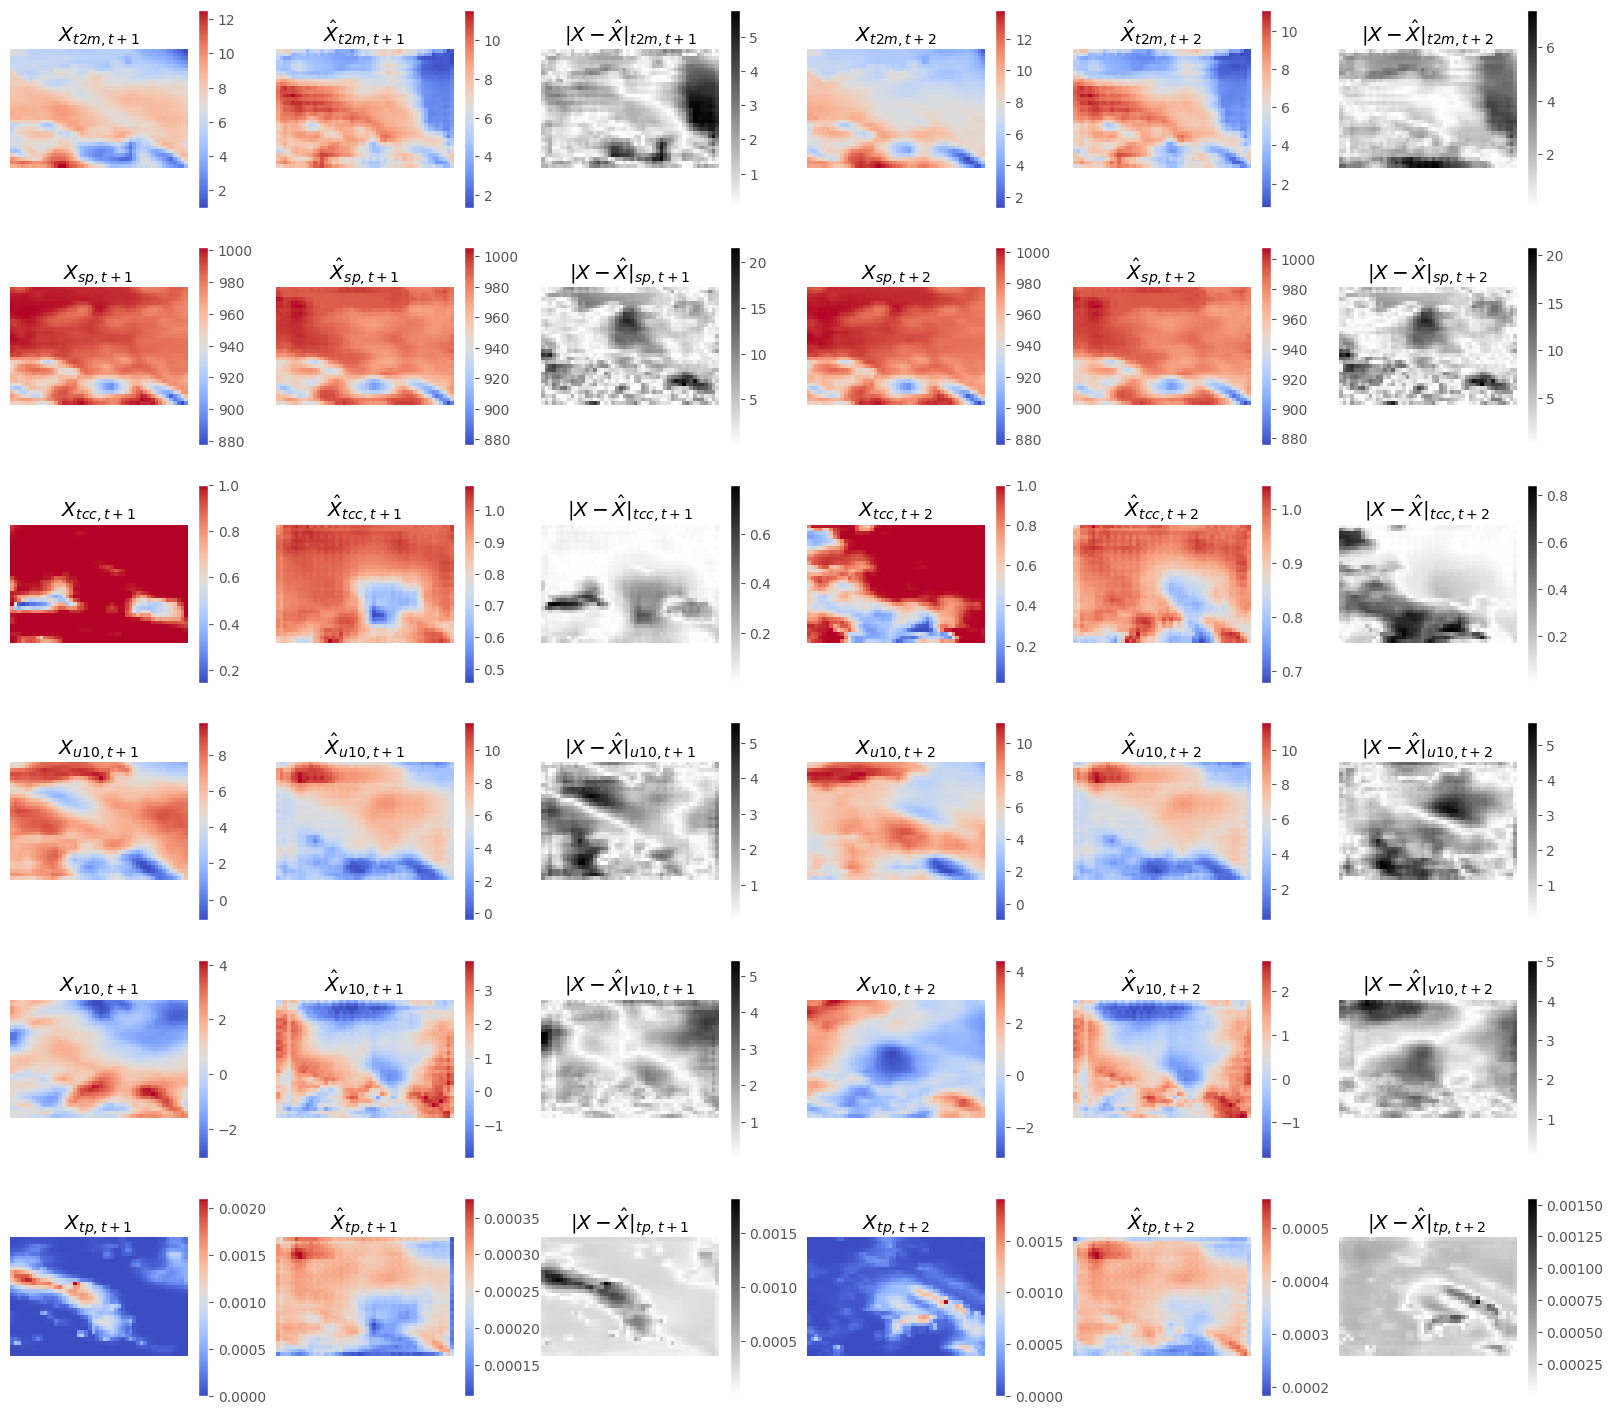

Evaluation metrics for entire test set:
t2m => RMSE: 3.671999931335449;
sp => RMSE: 8.385000228881836;
tcc => RMSE: 0.32100000977516174;
u10 => RMSE: 2.3970000743865967;
v10 => RMSE: 2.0810000896453857;
tp => RMSE: 0.0;


In [23]:
y_hat = []
y = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[:, :s, ...].reshape(batch.shape[0], s*n_features, batch.shape[3], batch.shape[4]).to(device)
        labels = np.array(batch[:, -fh:, ...].reshape(batch.shape[0], fh*n_features, batch.shape[3], batch.shape[4]).cpu())
        labels = labels.reshape(labels.shape[1:]).transpose(1, 2, 0).reshape(labels.shape[2], labels.shape[3], fh, n_features)
        y.append(labels)
        outputs = np.array(model(inputs).cpu())
        outputs = outputs.reshape(outputs.shape[1:]).transpose(1, 2, 0).reshape(outputs.shape[2], outputs.shape[3], fh, n_features)
        y_hat.append(outputs)

y_hat = np.array(y_hat)
y = np.array(y)
for i in range(n_features):
    og_shape = y_hat[..., i].shape
    y_hat[..., i] = scalers[i].inverse_transform(y_hat[..., i].reshape(-1, 1)).reshape(og_shape)
    og_shape = y[..., i].shape
    y[..., i] = scalers[i].inverse_transform(y[..., i].reshape(-1, 1)).reshape(og_shape)

plot_predictions(y_hat, y, max_samples=1)

print("=======================================")
print("Evaluation metrics for entire test set:")
print("=======================================")

rmse_features = []
for i in range(n_features):
    y_hat_i = y_hat[..., i].reshape(-1, 1)
    y_test_i = y[..., i].reshape(-1, 1)
    err = round(np.sqrt(mean_squared_error(y_hat_i, y_test_i)), 3)
    rmse_features.append(err)
for i in range(n_features):
    print(
        f"{feature_list[i]} => RMSE: {rmse_features[i]};"
    )

In [ ]:
"""
=======================================
Evaluation metrics for entire test set:
=======================================
t2m => RMSE: 3.38100004196167;
sp => RMSE: 8.74899959564209;
tcc => RMSE: 0.2750000059604645;
u10 => RMSE: 2.194000005722046;
v10 => RMSE: 2.5920000076293945;
tp => RMSE: 0.0;
BAD results.
"""
0